# model 5 (500)
one-hot encoded cell_type + top 500 variance Transformer_CNN_BindingDB affinities

In [1]:
import polars as pl
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# import from the auxFunctions.py file
from auxFunctions import calculate_mae_and_mrrmse, mean_rowwise_rmse_loss, custom_mean_rowwise_rmse, create_model_checkpoint, plot_training_history

## pre-process data
one-hot encode cell type
<br>map sm_name to affinities500_Transformer_CNN_BindingDB.csv

In [2]:
de_train = pl.scan_parquet('./kaggledata/de_train.parquet')
de_train_df = de_train.collect().to_pandas()

# test provided by kaggle --> upload predictions to kaggle to get the score
id_map = pd.read_csv('./kaggledata/id_map.csv')

affinities = pd.read_csv('affinities500_Transformer_CNN_BindingDB.csv', index_col=0)

train dataset provided by kaggle
- will be split into train/test/validation for internal testing before model is trained on the entire train and used to predict on the test in id_map

In [3]:
def extractAffinities(sm_names, affinities):
    """
    Function to extract affinities from the affinities dataframe

    Parameters:
    - sm_names: List/Array of sm_names
    - affinities: Stored affinities predicted using DeepPurpose

    Returns:
    - Affinities as a numpy array
    """
    encoded_affinities = []
    for name in sm_names:
        filtered = affinities[affinities['sm_name'] == name]
        sm_affinities = filtered.iloc[:, 2:].values[0]
        encoded_affinities.append(sm_affinities)

    np_encoded_affinities = np.array(encoded_affinities)

    return np_encoded_affinities

In [4]:
# one-hot encode cell_type
cell_type = de_train_df['cell_type'].to_numpy().reshape(-1, 1)
encoder = OneHotEncoder()
encoder.fit(cell_type)
# of type scipy.sparse._csr.csr_matrix
encoded_cell_type = encoder.transform(cell_type)

# map sm_name to affinities
sm_name = de_train_df['sm_name']

# has shape (614, 500), of type numpy.ndarray
np_encoded_affinities = extractAffinities(sm_name, affinities)

# concatenate encoded_cell_type and np_encoded_affinities
# final shape (614, 506)
encoded_features = np.hstack((encoded_cell_type.toarray(), np_encoded_affinities))

# wanted output
genes_lfc = de_train_df.drop(columns=['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'])

In [5]:
# repeat for kaggle test set
kaggle_cell_type = id_map['cell_type'].to_numpy().reshape(-1, 1)
encoded_kaggle_cell_type = encoder.transform(kaggle_cell_type)

kaggle_sm_name = id_map['sm_name']
encoded_kaggle_affinities = extractAffinities(kaggle_sm_name, affinities)

# final shape (255, 506)
encoded_kaggle_features = np.hstack((encoded_kaggle_cell_type.toarray(), encoded_kaggle_affinities))

In [6]:
# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(encoded_features, genes_lfc.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# used for final training before predicting on kaggle_test
full_features = encoded_features
full_labels = genes_lfc.values

## model training

In [7]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [17]:
tf.random.set_seed(42)

model_5_500 = Sequential([
        Dense(3400, activation="tanh"),
        Dense(3000, activation="tanh"),
        Dense(2100, activation="tanh"),
        Dense(200, activation="tanh"),
        Dense(200, activation="tanh"),
        Dropout(0.25),
        Dense(18211, activation="linear")
    ])

model_5_500.compile(loss=mean_rowwise_rmse_loss, 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=[custom_mean_rowwise_rmse])

history_5_500 = model_5_500.fit(X_train, y_train,
                       epochs=10,
                       validation_data=(X_val,y_val),
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_2", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
14/14 [==============================] - 9s 512ms/step - loss: 1.4362 - custom_mean_rowwise_rmse: 1.4346 - val_loss: 0.8925 - val_custom_mean_rowwise_rmse: 0.8909
Epoch 2/10
14/14 [==============================] - 7s 481ms/step - loss: 1.4195 - custom_mean_rowwise_rmse: 1.4289 - val_loss: 0.8893 - val_custom_mean_rowwise_rmse: 0.8873
Epoch 3/10
14/14 [==============================] - 7s 474ms/step - loss: 1.4214 - custom_mean_rowwise_rmse: 1.3975 - val_loss: 0.8823 - val_custom_mean_rowwise_rmse: 0.8805
Epoch 4/10
14/14 [==============================] - 6s 465ms/step - loss: 1.4167 - custom_mean_rowwise_rmse: 1.4306 - val_loss: 0.8725 - val_custom_mean_rowwise_rmse: 0.8706
Epoch 5/10
14/14 [==============================] - 6s 400ms/step - loss: 1.4102 - custom_mean_rowwise_rmse: 1.4473 - val_loss: 0.8791 - val_custom_mean_rowwise_rmse: 0.8769
Epoch 6/10
14/14 [==============================] - 6s 463ms/step - loss: 1.4093 - custom_mean_rowwise_rmse: 1.3857 - val_loss: 0.

### evaluate model

In [18]:
calculate_mae_and_mrrmse(model=model_5_500, data=X_test, y_true=y_test)

93/93 [==============================] - 1s 10ms/step
Mean Absolute Error (MAE): 0.8941087559637675
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.3611565303529023


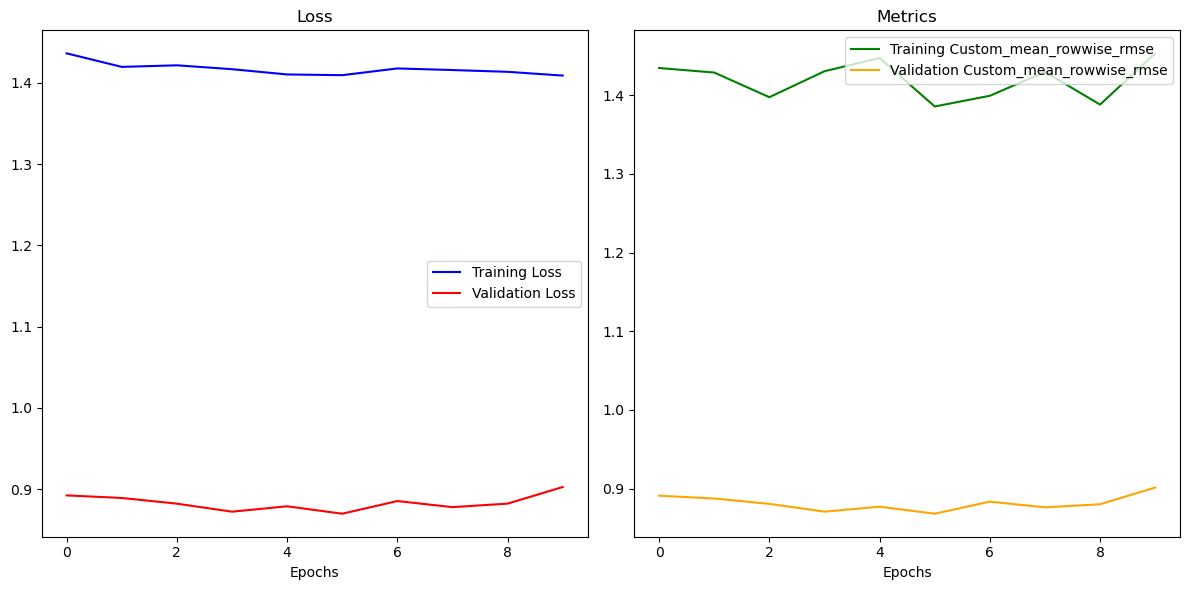

In [19]:
plot_training_history(history_5_500, metrics=["custom_mean_rowwise_rmse"])

# predict on full kaggle set

In [30]:
tf.random.set_seed(42)

model_5_500_full = Sequential([
        Dense(3400, activation="tanh"),
        Dense(3000, activation="tanh"),
        Dense(2100, activation="tanh"),
        Dense(200, activation="tanh"),
        Dense(200, activation="tanh"),
        Dropout(0.25),
        Dense(18211, activation="linear")
    ])

model_5_500_full.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=[custom_mean_rowwise_rmse])

history_5_500_full = model_5_500_full.fit(full_features, full_labels,
                       epochs=10,
                       batch_size=32)

Epoch 1/10
20/20 [==============================] - 11s 384ms/step - loss: 0.9052 - custom_mean_rowwise_rmse: 1.3309
Epoch 2/10
20/20 [==============================] - 7s 356ms/step - loss: 0.9027 - custom_mean_rowwise_rmse: 1.3136
Epoch 3/10
20/20 [==============================] - 7s 370ms/step - loss: 0.9030 - custom_mean_rowwise_rmse: 1.3060
Epoch 4/10
20/20 [==============================] - 7s 362ms/step - loss: 0.9022 - custom_mean_rowwise_rmse: 1.3069
Epoch 5/10
20/20 [==============================] - 7s 368ms/step - loss: 0.9026 - custom_mean_rowwise_rmse: 1.3445
Epoch 6/10
20/20 [==============================] - 7s 368ms/step - loss: 0.9137 - custom_mean_rowwise_rmse: 1.3483
Epoch 7/10
20/20 [==============================] - 7s 326ms/step - loss: 0.9153 - custom_mean_rowwise_rmse: 1.3169
Epoch 8/10
20/20 [==============================] - 7s 366ms/step - loss: 0.9075 - custom_mean_rowwise_rmse: 1.3133
Epoch 9/10
20/20 [==============================] - 7s 325ms/step - los

In [27]:
kaggle_predictions = model_5_500_full.predict(encoded_kaggle_features, batch_size=1)

255/255 [==============================] - 2s 6ms/step


In [28]:
sample_submission = pd.read_csv('./kaggledata/sample_submission.csv')
sample_submission.iloc[:,1:] = kaggle_predictions

sample_submission.to_csv('submission_model_5_500.csv', index=False)